<a href="https://colab.research.google.com/github/AnDDoanf/OCR-repos/blob/master/OCR-CNN-RNN-captcha.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
os.environ["KAGGLE_CONFIG_DIR"] = "/content/drive/MyDrive/Kaggle"
%cd /content/drive/MyDrive/Kaggle

/content/drive/MyDrive/Kaggle


In [2]:
# !kaggle datasets download -d fournierp/captcha-version-2-images
# !unzip *.zip -d capcha-data
# !rm *.zip

In [3]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

In [4]:
data_dir = Path("./capcha-data/samples")
images = list(data_dir.glob("*.png"))
len(images)

1040

In [5]:
characters = set()
captcha_length = []
dataset = []
for img_path in images:
    # 1. Get the label associated with each image
    label = img_path.name.split(".png")[0]
    # 2. Store the length of this cpatcha
    captcha_length.append(len(label))
    # 3. Store the image-label pair info
    dataset.append((str(img_path), label))

    # 4. Store the characters present
    for ch in label:
        characters.add(ch)

# Sort the characters
characters = sorted(characters)

# Convert the dataset info into a dataframe
dataset = pd.DataFrame(dataset, columns=["img_path", "label"], index=None)

# Shuffle the dataset
dataset = dataset.sample(frac=1.).reset_index(drop=True)


print("Number of unqiue charcaters in the whole dataset: ", len(characters))
print("Maximum length of any captcha: ", max(Counter(captcha_length).keys()))
print("Characters present: ", characters)
print("Total number of samples in the dataset: ", len(dataset))
dataset.head()

Number of unqiue charcaters in the whole dataset:  19
Maximum length of any captcha:  5
Characters present:  ['2', '3', '4', '5', '6', '7', '8', 'b', 'c', 'd', 'e', 'f', 'g', 'm', 'n', 'p', 'w', 'x', 'y']
Total number of samples in the dataset:  1040


,img_path,label
0,capcha-data/samples/cen55.png,cen55
1,capcha-data/samples/pw5nc.png,pw5nc
2,capcha-data/samples/57b27.png,57b27
3,capcha-data/samples/3w2bw.png,3w2bw
4,capcha-data/samples/p24gn.png,p24gn


Shape of image:  (50, 200, 3)
Shape of image:  (50, 200, 3)
Shape of image:  (50, 200, 3)
Shape of image:  (50, 200, 3)


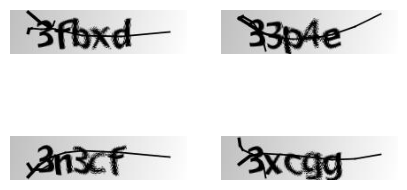

In [6]:
sample_images = images[:4]

_,ax = plt.subplots(2,2, figsize=(5,3))
for i in range(4):
    img = cv2.imread(str(sample_images[i]))
    print("Shape of image: ", img.shape)
    ax[i//2, i%2].imshow(img)
    ax[i//2, i%2].axis('off')
plt.show()

In [7]:
train_data, val_data = train_test_split(dataset, test_size=0.1, random_state=seed)

train_data = train_data.reset_index(drop=True)
val_data = val_data.reset_index(drop=True)

train_data.shape, val_data.shape

((936, 2), (104, 2))

In [8]:
char_to_labels = {char:idx for idx, char in enumerate(characters)}
labels_to_char = {val:key for key, val in char_to_labels.items()}

def is_valid_captcha(captcha):
    for ch in captcha:
        if not ch in characters:
            return False
    return True

def generate_arrays(df, resize=True, img_height=50, img_width=200):
    num_items = len(df)
    images = np.zeros((num_items, img_height, img_width), dtype=np.float32)
    labels = [0]*num_items

    for i in range(num_items):
        img = cv2.imread(df["img_path"][i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        if resize:
            img = cv2.resize(img, (img_width, img_height))

        img = (img/255.).astype(np.float32)
        label = df["label"][i]

        # Add only if it is a valid captcha
        if is_valid_captcha(label):
            images[i, :, :] = img
            labels[i] = label

    return images, np.array(labels)



# Build training data
X_train, y_train = generate_arrays(df=train_data)

# Build validation data
X_val, y_val = generate_arrays(df=val_data)

X_train.shape, y_train.shape, X_val.shape, y_val.shape

((936, 50, 200), (936,), (104, 50, 200), (104,))

In [9]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self,
                 data,
                 labels,
                 char_map,
                 batch_size=16,
                 img_width=200,
                 img_height=50,
                 downsample_factor=4,
                 max_length=5,
                 shuffle=True
                ):
        self.data = data
        self.labels = labels
        self.char_map = char_map
        self.batch_size = batch_size
        self.img_width = img_width
        self.img_height = img_height
        self.downsample_factor = downsample_factor
        self.max_length = max_length
        self.shuffle = shuffle
        self.indices = np.arange(len(data))
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.data) / self.batch_size))

    def __getitem__(self, idx):
        curr_batch_idx = self.indices[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_len = len(curr_batch_idx)
        batch_images = np.ones((batch_len, self.img_width, self.img_height, 1),
                               dtype=np.float32)
        batch_labels = np.ones((batch_len, self.max_length), dtype=np.float32)
        input_length = np.ones((batch_len, 1), dtype=np.int64) * \
                                (self.img_width // self.downsample_factor - 2)
        label_length = np.zeros((batch_len, 1), dtype=np.int64)

        for j, idx in enumerate(curr_batch_idx):
            img = self.data[idx].T
            img = np.expand_dims(img, axis=-1)
            text = self.labels[idx]

            if is_valid_captcha(text):
                label = [self.char_map[ch] for ch in text]
                batch_images[j] = img
                batch_labels[j] = label
                label_length[j] = len(text)

        batch_inputs = {
                'input_data': batch_images,
                'input_label': batch_labels,
                'input_length': input_length,
                'label_length': label_length,
                }
        return batch_inputs, np.zeros(batch_len).astype(np.float32)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

In [10]:
# Batch size for training and validation
batch_size = 16

# Desired image dimensions
img_width=200
img_height=50

# Factor  by which the image is going to be downsampled
# by the convolutional blocks
downsample_factor=4

# Maximum length of any captcha in the data
max_length=5

# Get a generator object for the training data
train_data_generator = DataGenerator(data=X_train,
                                     labels=y_train,
                                     char_map=char_to_labels,
                                     batch_size=batch_size,
                                     img_width=img_width,
                                     img_height=img_height,
                                     downsample_factor=downsample_factor,
                                     max_length=max_length,
                                     shuffle=True
                                    )

# Get a generator object for the validation data
valid_data_generator = DataGenerator(data=X_val,
                                     labels=y_val,
                                     char_map=char_to_labels,
                                     batch_size=batch_size,
                                     img_width=img_width,
                                     img_height=img_height,
                                     downsample_factor=downsample_factor,
                                     max_length=max_length,
                                     shuffle=False
                                    )

In [17]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred, input_length, label_length):
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)
        return loss



def build_model():
    input_img = layers.Input(shape=(img_width, img_height, 1),
                            name='input_data',
                            dtype='float32')
    labels = layers.Input(name='input_label', shape=[max_length], dtype='float32')
    input_length = layers.Input(name='input_length', shape=[1], dtype='int64')
    label_length = layers.Input(name='label_length', shape=[1], dtype='int64')

    x = layers.Conv2D(32,
               (3,3),
               activation='relu',
               kernel_initializer='he_normal',
               padding='same',
               name='Conv1')(input_img)
    x = layers.MaxPooling2D((2,2), name='pool1')(x)

    x = layers.Conv2D(64,
               (3,3),
               activation='relu',
               kernel_initializer='he_normal',
               padding='same',
               name='Conv2')(x)
    x = layers.MaxPooling2D((2,2), name='pool2')(x)

    new_shape = ((img_width // 4), (img_height // 4)*64)
    x = layers.Reshape(target_shape=new_shape, name='reshape')(x)
    x = layers.Dense(64, activation='relu', name='dense1')(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Bidirectional(layers.LSTM(128,
                                         return_sequences=True,
                                         dropout=0.2))(x)
    x = layers.Bidirectional(layers.LSTM(64,
                                         return_sequences=True,
                                         dropout=0.25))(x)
    x = layers.Dense(len(characters)+1,
              activation='softmax',
              name='dense2',
              kernel_initializer='he_normal')(x)

    output = CTCLayer(name='ctc_loss')(labels, x, input_length, label_length)

    model = keras.models.Model(inputs=[input_img,
                                       labels,
                                       input_length,
                                       label_length],
                                outputs=output,
                                name='ocr_model_v1')
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=2e-3,
        decay_steps=100,
        decay_rate=0.9)

    sgd = keras.optimizers.SGD(learning_rate=lr_schedule,
                               momentum=0.9,
                               nesterov=True,
                               clipnorm=5,
                               )

    model.compile(optimizer=sgd)
    return model

In [12]:
model = build_model()
model.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_data (InputLayer)     [(None, 200, 50, 1)]         0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 200, 50, 32)          320       ['input_data[0][0]']          
                                                                                                  
 pool1 (MaxPooling2D)        (None, 100, 25, 32)          0         ['Conv1[0][0]']               
                                                                                                  
 Conv2 (Conv2D)              (None, 100, 25, 64)          18496     ['pool1[0][0]']               
                                                                                       

In [19]:
# Train the model
history = model.fit(train_data_generator,
                    validation_data=valid_data_generator,
                    epochs=50)

Epoch 1/50
59/59 [==============================] - 2s 29ms/step - loss: 15.9936 - val_loss: 15.9449
Epoch 2/50
59/59 [==============================] - 2s 41ms/step - loss: 15.9919 - val_loss: 15.9642
Epoch 3/50
59/59 [==============================] - 3s 43ms/step - loss: 15.9842 - val_loss: 15.9632
Epoch 4/50
59/59 [==============================] - 2s 32ms/step - loss: 15.9810 - val_loss: 15.8900
Epoch 5/50
59/59 [==============================] - 2s 26ms/step - loss: 15.9670 - val_loss: 15.9435
Epoch 6/50
59/59 [==============================] - 2s 27ms/step - loss: 15.9603 - val_loss: 15.9532
Epoch 7/50
59/59 [==============================] - 2s 27ms/step - loss: 15.9545 - val_loss: 15.8539
Epoch 8/50
59/59 [==============================] - 2s 27ms/step - loss: 15.9469 - val_loss: 15.9143
Epoch 9/50
59/59 [==============================] - 3s 43ms/step - loss: 15.9282 - val_loss: 15.8919
Epoch 10/50
59/59 [==============================] - 2s 29ms/step - loss: 15.9228 - val_los

In [20]:
prediction_model = keras.models.Model(model.get_layer(name='input_data').input,
                                        model.get_layer(name='dense2').output)

In [21]:
# A utility to decode the output of the network
def decode_batch_predictions(pred):
    pred = pred[:, :-2]
    input_len = np.ones(pred.shape[0])*pred.shape[1]

    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred,
                                        input_length=input_len,
                                        greedy=True)[0][0]

    # Iterate over the results and get back the text
    output_text = []
    for res in results.numpy():
        outstr = ''
        for c in res:
            if c < len(characters) and c >=0:
                outstr += labels_to_char[c]
        output_text.append(outstr)

    # return final text results
    return output_text

In [22]:
#  Let's check results on some validation samples
for p, (inp_value, _) in enumerate(valid_data_generator):
    bs = inp_value['input_data'].shape[0]
    X_data = inp_value['input_data']
    labels = inp_value['input_label']

    preds = prediction_model.predict(X_data)
    pred_texts = decode_batch_predictions(preds)


    orig_texts = []
    for label in labels:
        text = ''.join([labels_to_char[int(x)] for x in label])
        orig_texts.append(text)

    for i in range(bs):
        print(f'Ground truth: {orig_texts[i]} \t Predicted: {pred_texts[i]}')
    break

1/1 [==============================] - 1s 1s/step
Ground truth: wyc25 	 Predicted: wyc25
Ground truth: 8n65n 	 Predicted: 8n65n
Ground truth: cnex4 	 Predicted: cnex4
Ground truth: e3ndn 	 Predicted: e3ndn
Ground truth: 3nnpw 	 Predicted: 3nnpw
Ground truth: 474ff 	 Predicted: 474ff
Ground truth: ffnxn 	 Predicted: ffnxn
Ground truth: 6bdn5 	 Predicted: 6bdn5
Ground truth: cb8cf 	 Predicted: cb8cf
Ground truth: cdfen 	 Predicted: cdfen
Ground truth: 6e554 	 Predicted: 6e554
Ground truth: 3b4we 	 Predicted: 3b4we
Ground truth: 4ycex 	 Predicted: 4ycex
Ground truth: 658xe 	 Predicted: 658xe
Ground truth: b685n 	 Predicted: b685n
Ground truth: x76mn 	 Predicted: x76mn
